In [18]:
import nibabel
from nibabel import freesurfer
import nibabel.affines
from PIL import Image
import os
import fnmatch
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import ants
import scipy.io as sio

np.set_printoptions(precision=2, suppress=True)

### File handling and loading functions

In [19]:
# Load an image into nibabel
def load_image(data_path, filename):
    
    return nibabel.load(f"{data_path}/{filename}")

# Display the middle slice of a nibabel image
def display_image(image):

    # Get image data array from image object
    image_array = np.asarray(image.dataobj)
    
    # Get middle slice
    slice = image_array[image_array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Display the middle slice of a 3d array
def display_array(array):
    
    # Get middle slice
    slice = array[array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Find files with a specific filename and return a list. Non-recursive 
def list_files_ext(data_path, extensions):

    files = [f for f in os.listdir(data_path) if f.endswith(extensions)]
        
    return files       

# Return the absolute path to all files matching a filename in a directory. Recursive
def list_files_fname(data_path, filename):
    
    matched_files = []
    
    for root, dirs, files in os.walk(data_path):
        
        for file in fnmatch.filter(files, filename):
            
            matched_files.append(os.path.join(root, file))
    
    return matched_files


### Image manipulation functions

In [20]:

# Returns a list of tuples, each containing an orig_nu.mgz and mask.mgz of a subject in the data_path
def get_mask_and_brain(data_path):
    
    brain_mask_list = []

    for item in os.listdir(data_path):
        
        subject_path = os.path.join(data_path, item)
        
        if os.path.isdir(subject_path):
            
            # MRI directory of subject path
            mri_path = os.path.join(subject_path, 'mri')
            
            # Check for MRI directory
            if os.path.isdir(mri_path):
                
                orig_file = os.path.join(mri_path, 'orig_nu.mgz')
                
                mask_file = os.path.join(mri_path, 'mask.mgz')

                # If both orig.mgz and mask.mgz exist, add them to the result
                if os.path.isfile(orig_file) and os.path.isfile(mask_file):
                    
                    brain_mask_list.append((orig_file, mask_file))

    return brain_mask_list

# Performs brain extraction using the orig_nu.mgz and mask.mgz of the subject by multiplying the mask with the image
def extract_brain(orig_file, mask_file):
    
    # Load the image and the brain mask
    image = nibabel.load(orig_file)
    mask = nibabel.load(mask_file)
    
    # Get their image arrays
    image_array = np.asarray(image.dataobj)
    mask_array = np.asarray(mask.dataobj)
    
    # Apply the mask, the mask entries are 1 or 0
    brain_array = image_array * mask_array
    
    return brain_array

### Reference brain

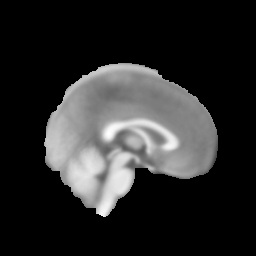

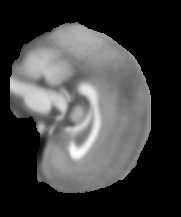

In [21]:
# NB seems that fastsrufer brain is better
reference_brain_array_fastsurfer = extract_brain("mni_icbm152_lin_nifti/fastsurfer-processed/mri/orig_nu.mgz", "mni_icbm152_lin_nifti/fastsurfer-processed/mri/mask.mgz")

display_array(reference_brain_array_fastsurfer)

reference_brain_array_mni = extract_brain("mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin.nii", "mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin_mask.nii")

display_array(reference_brain_array_mni)


In [22]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-1yr-3t"

# List of masks
fpath_list = list_files_fname(data_path, "mask.mgz")

# Number of masks
print(f"{len(fpath_list)}\n")


355



(256, 256, 256)


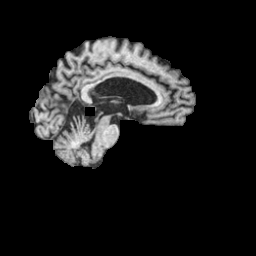

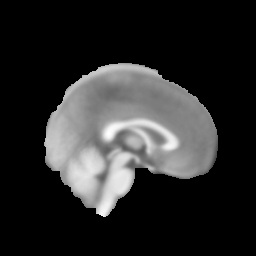

(256, 256, 256)
{'AffineTransform_float_3_3': array([[  0.91],
       [ -0.15],
       [  0.08],
       [  0.15],
       [  0.83],
       [ -0.11],
       [ -0.03],
       [  0.09],
       [  0.91],
       [  3.3 ],
       [-34.57],
       [-18.  ]], dtype=float32), 'fixed': array([[127.91],
       [136.08],
       [123.86]], dtype=float32)}


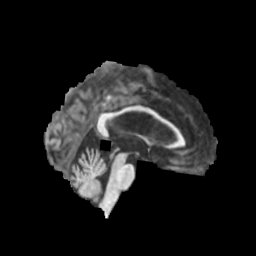

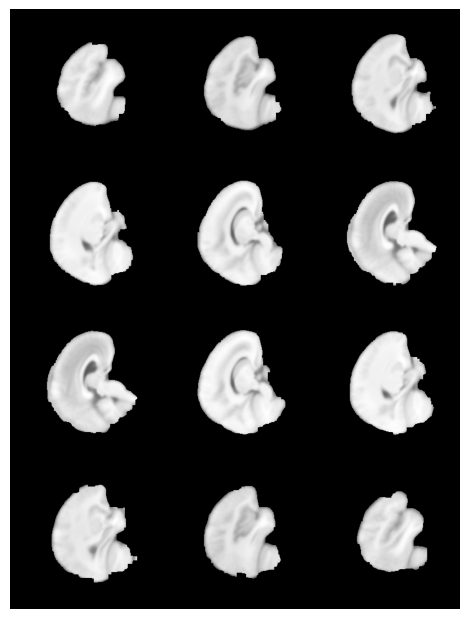

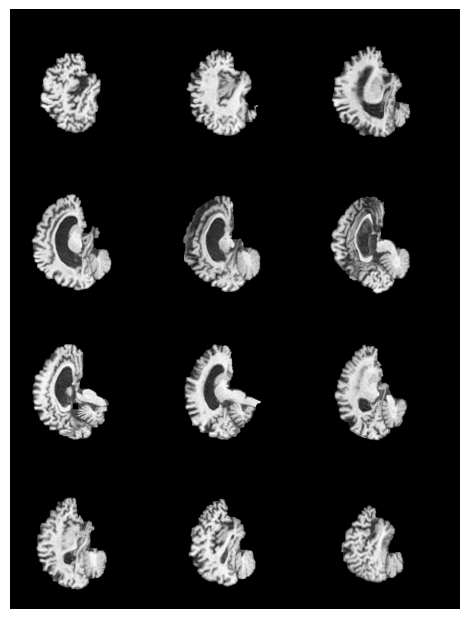

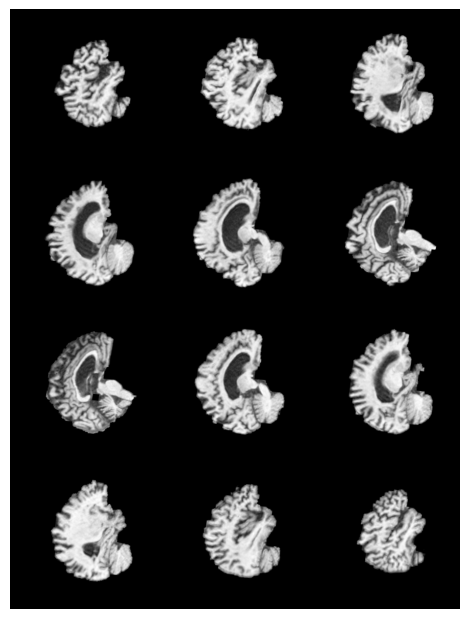

In [ ]:
for subject in get_mask_and_brain(data_path):
    
    # Extract brain of subject and convert it to an ANTsPy image
    # The subject's brain is the moving image
    brain_array = extract_brain(subject[0], subject[1])
    
    print(brain_array.shape)
    
    display_array(brain_array)
    
    moving_image = ants.from_numpy(brain_array)
    
    # Convert the reference brain to an ANTsPy image
    # The reference brain is already extracted
    fixed_image = ants.from_numpy(reference_brain_array_fastsurfer)
    
    display_array(reference_brain_array_fastsurfer)

    print(reference_brain_array_fastsurfer.shape)
    
    # Perform registration using ANTsPy
    # NB need to decide parameters and deal with runtime
    registration = ants.registration(fixed = fixed_image, moving = moving_image, type_of_transform='AffineFast')
    
    aligned_brain_array = registration['warpedmovout'].numpy()
    
    # Load the .mat file containing the transformation
    transformation = sio.loadmat(registration['fwdtransforms'][0])
    
    print(transformation)
        
    display_array(registration['warpedmovout'].numpy())
    
    fixed_image.plot()
    
    moving_image.plot()
    
    registration['warpedmovout'].plot()

    break

            